## Prepare train_data and test_data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from hypergbm import make_experiment
from hypernets.tabular.metrics import metric_to_scoring


In [2]:
train_data = pd.read_csv('datasets/Magic/train.csv.gz')
test_data = pd.read_csv('datasets/Magic/test.csv.gz')
X_train = train_data.copy()
y_train = X_train.pop('Class')
X_test = test_data.copy()
y_test = X_test.pop('Class')

# Check  features difference between train&test

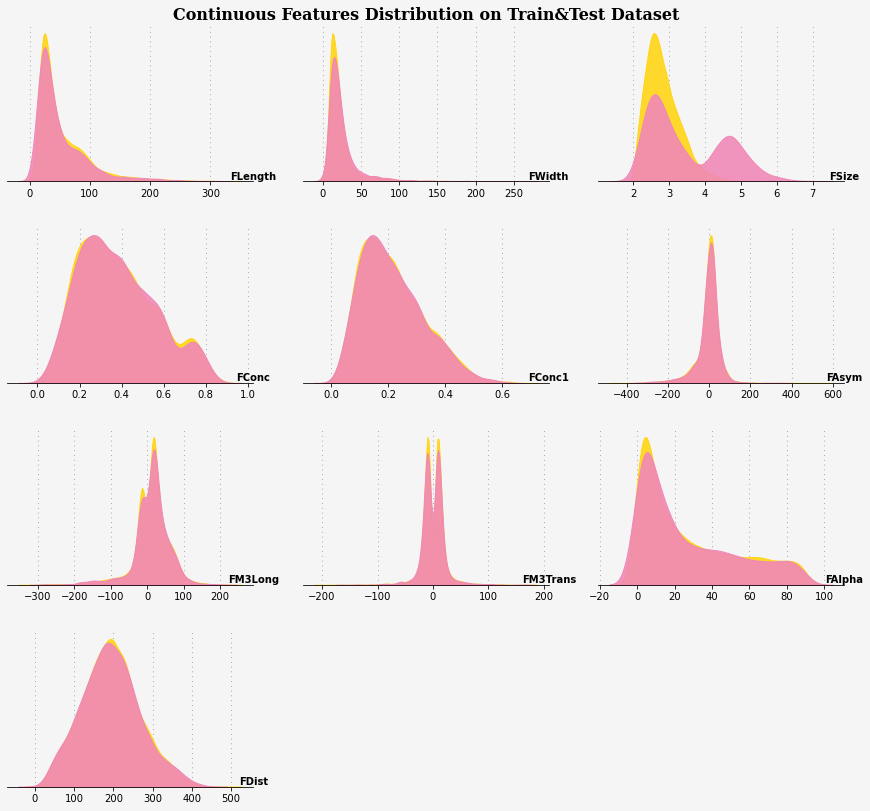

In [3]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
def show_continuous_features(X_train,X_test,num_feature):
    _col = 3
    _len = len(num_feature)
    fig = plt.figure(figsize=(15, math.ceil(_len / _col)*3.5), facecolor='#f6f5f5')
    gs = fig.add_gridspec(math.ceil(_len / _col), _col)
    gs.update(wspace=0.2, hspace=0.3)
    background_color = "#f6f5f5"
    run_no = 0
    for row in range(0, math.ceil(len(num_feature) / _col)):
        for col in range(0, _col):
            if row * _col + col >= len(num_feature):
                break
            locals()["ax" + str(run_no)] = fig.add_subplot(gs[row, col])
            locals()["ax" + str(run_no)].set_facecolor(background_color)
            locals()["ax" + str(run_no)].set_yticklabels([])
            locals()["ax" + str(run_no)].tick_params(axis='y', which=u'both', length=0)
            for s in ["top", "right", 'left']:
                locals()["ax" + str(run_no)].spines[s].set_visible(False)
            run_no += 1
    locals()['ax1'].set_title('Continuous Features Distribution on Train&Test Dataset', fontsize=16, fontweight='bold',
                              fontfamily='serif')
    run_no = 0
    for col in num_feature:
        sns.kdeplot(X_train[col],ax=locals()["ax" + str(run_no)], shade=True, color='#ffd514', alpha=0.9, zorder=2)
        sns.kdeplot(X_test[col], ax=locals()["ax" + str(run_no)], shade=True, color='#f088b7', alpha=0.9, zorder=2)
        locals()["ax" + str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':',
                                          dashes=(1, 5))
        locals()["ax" + str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
        locals()["ax" + str(run_no)].yaxis.set_label_coords(1, 0)
        locals()["ax" + str(run_no)].set_xlabel('')
        run_no += 1
    plt.show()
show_continuous_features(X_train,X_test,X_train.columns)

# Use Concept Drift Detection
Concept drift in the input data is one of the main challenges. Over time, it will worsen the performance of model on new data. We introduce an adversarial validation approach to concept drift problems. This approach will detect concept drift and identify the drifted features and process them automatically.
    
* drift_detection : bool,(default=True),enable data drift detection and processing or not. Only valid when *test_data* is provided. 
* drift_detection_remove_shift_variable : bool, (default=True)
* drift_detection_variable_shift_threshold : float, (default=0.7)
* drift_detection_threshold : float, (default=0.7)

* drift_detection_remove_size : float, (default=0.1)
* drift_detection_min_features : int, (default=10)
* drift_detection_num_folds : int, (default=5)

In [4]:
experiment = make_experiment(train_data.copy(),test_data=X_test.copy(), target='Class',
                             reward_metric='precision', pos_label=1,
                             random_state=1234, max_trials=10, early_stopping_rounds=0,
                             drift_detection=True,
                             drift_detection_variable_shift_threshold=0.6,
                             )
estimator = experiment.run()


In [5]:
estimator.steps

[('data_clean',
  DataCleanStep(cv=True,
                data_cleaner_args={'correct_object_dtype': True,
                                   'drop_columns': None,
                                   'drop_constant_columns': True,
                                   'drop_duplicated_columns': False,
                                   'drop_idness_columns': True,
                                   'drop_label_nan_rows': True,
                                   'int_convert_to': 'float', 'nan_chars': None,
                                   'reduce_mem_usage': False,
                                   'reserve_columns': None},
                name='data_clean')),
 ('drift_detection',
  DriftDetectStep(min_features=10, name='drift_detection', num_folds=5,
                  remove_shift_variable=True, remove_size=0.1, threshold=0.7,
                  variable_shift_threshold=0.6)),
 ('estimator',
  GreedyEnsemble(weight=[0.85, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scores=[0.897931502

In [6]:
scorer = metric_to_scoring('precision',pos_label=1)
score = scorer(estimator, X_test, y_test)
score

0.8929110105580694